# Workshop 2: Handwritten digit classification with PyTorch
In this workshop we will learn how to train a neural network with images 
as input to classify hand-written digits
([info of the data](http://yann.lecun.com/exdb/mnist/)). The main blocks of the workshop are:

1. Get the data from PyTorch repository and visualize it.
2. Pre-process the data.
3. Design the network.
4. Train the network.
5. Evaluate the model.

# 1. Get the data from PyTorch repository and visualize it.

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# set random seed for reproducibility
torch.manual_seed(42)

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 280377052.60it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112999714.39it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 145929511.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21972928.22it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train

In [5]:
train_dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FDC2DEB0610>, 5)

In [6]:
train_dataset[0][0].show()  # imprimir el primer elemento de la primera tupla

In [7]:
sample_array = np.array(train_dataset[0][0])
print("Sample shape:", sample_array.shape)
print("Sample min value:", sample_array.min())
print("Sample max value:", sample_array.max())

Sample shape: (28, 28)
Sample min value: 0
Sample max value: 255


In [8]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test

In [9]:
test_dataset[0]   # imprime la tupla: (imagen, annotación/ label de que es la imagen)

(<PIL.Image.Image image mode=L size=28x28 at 0x7FDC2DEB25F0>, 7)

In [10]:
test_dataset[0][0].show()

# 2. Pre-process the data.

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)   # descargar datasets
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
# Split the test set into validation and test sets
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [5000, 5000])         # splits the test_dataset into two separate datasets: valid_dataset and test_dataset with each 5000 values
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)                           # estructura de datos, me manda batches de 64 datos; shuffle: para no aprender durante la fase del entrenamiento de los batches 
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
images, labels = next(iter(train_loader))
print("Sample shape:", images.shape)
print("Sample min value:", images.min())
print("Sample max value:", images.max())

Sample shape: torch.Size([64, 1, 28, 28])
Sample min value: tensor(0.)
Sample max value: tensor(1.)


In this case, the sample shape is torch.Size([64, 1, 28, 28]), which indicates the following:

* The first number, 64, represents the **batch size**. It indicates that there are 64 samples in the batch.
* The second number, 1, represents the **number of channels**. It indicates that each sample has 1 channel. In this context, it suggests that the input is grayscale since there is only one channel. If it were a color image, this number would typically be 3, representing the Red, Green, and Blue channels.
* The third number, 28, represents the **height of the sample image**. It indicates that each sample has a height of 28 pixels.
* The fourth number, 28, represents the **width of the sample image**. It indicates that each sample has a width of 28 pixels.

Therefore, the overall shape of each sample in the tensor is (1, 28, 28), representing a grayscale image with dimensions 28x28 pixels. The batch size is 64, implying that there are 64 such samples in the given tensor.

In [13]:
# Import dependence for visualization of images
plt.rcParams['figure.figsize'] = (10,10)  # Configure figure size for appropriate visualization

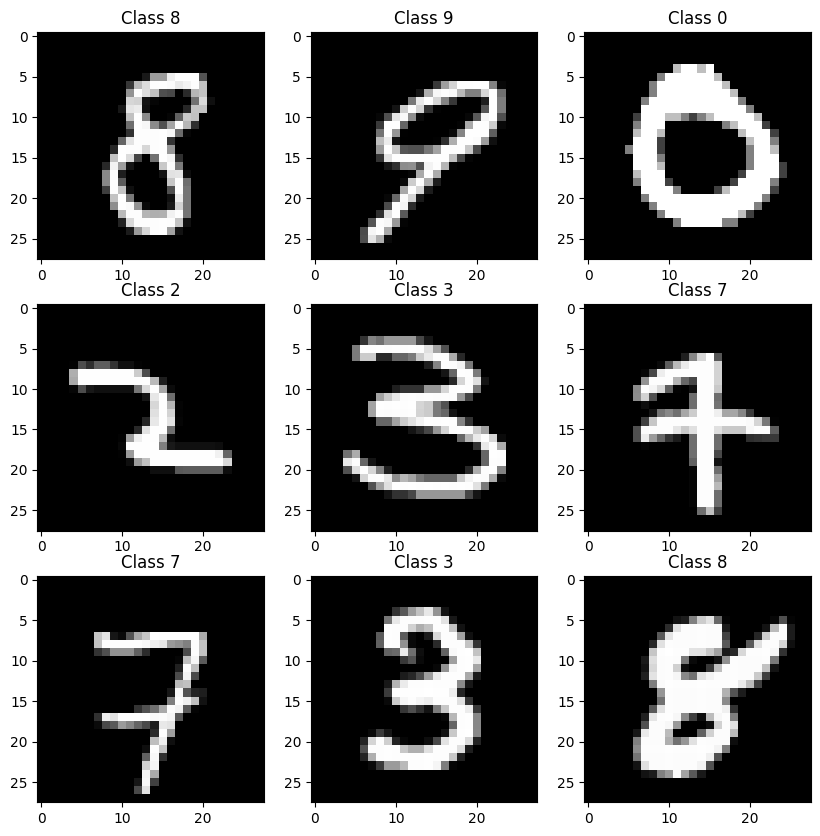

In [14]:
# Plot the images in a 3x3 grid
nrows = 3
ncols = 3
nsamples = nrows*ncols
for i in range(nsamples):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i, 0, :, :], cmap='gray', interpolation='none')
    plt.title("Class {}".format(labels[i]))

# 3. Design the network.

In [15]:
# Define model
class Net(nn.Module):                     # cualquier nombre de la red
    def __init__(self):                   # init siempre igual para decalar lasa capas de la red
        super(Net, self).__init__()       # en este caso: 2 capas fully-connected (= nn.Linear)
        self.fc1 = nn.Linear(784, 32)     # (variables de salida, num neuronas = num de clases)
        self.fc2 = nn.Linear(32, 10)  

    def forward(self, x):                # funcion como se conectan las capas
        x = x.view(-1, 784)              # hacer un reshape de x (los datos que entran); -1 la dimension del batch, 2° pixeles en una fila: 28*28
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)     # dim=0 es el batch, dim=1 son las clases
        return x

model = Net()

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [17]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]          25,120
            Linear-2                   [-1, 10]             330
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.10
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [18]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train the network.

In [19]:
def get_accuracy(y_pred, y_true):
    """Calculate the accuracy between predicted and true labels"""
    _, y_pred = torch.max(y_pred, dim=1)
    correct = torch.sum(y_pred == y_true).float()
    acc = correct / len(y_true)
    return acc

In [20]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):                         # iterar por cada epoch: en cada epoch 
    for i, (images, labels) in enumerate(train_loader): # recorre por todo el datasaet train_loader

        # Clear gradients (para reiniciarlos)
        optimizer.zero_grad()

        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass (con tu batch)            
        outputs = model(images)     # crear predicciones de nuestro batch

        # Compute loss
        loss = criterion(outputs, labels)     # calcular para luego poder cambiar los pesos del modelo

        # Backward pass 
        loss.backward()     # calcular los gradientes para los pesos

        # Update weights
        optimizer.step()    # en consequiencia de los gradientes que hemos calculado

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference  (eso no cambia la red, solo para poder ver como va nuestro modelo)
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.558 | Train accuracy: 0.917 | Valid loss: 1.551 | Valid accuracy: 0.923
Epoch 2/10 | Train loss: 1.543 | Train accuracy: 0.927 | Valid loss: 1.536 | Valid accuracy: 0.933
Epoch 3/10 | Train loss: 1.534 | Train accuracy: 0.934 | Valid loss: 1.529 | Valid accuracy: 0.938
Epoch 4/10 | Train loss: 1.527 | Train accuracy: 0.941 | Valid loss: 1.525 | Valid accuracy: 0.942
Epoch 5/10 | Train loss: 1.521 | Train accuracy: 0.946 | Valid loss: 1.518 | Valid accuracy: 0.946
Epoch 6/10 | Train loss: 1.517 | Train accuracy: 0.949 | Valid loss: 1.517 | Valid accuracy: 0.949
Epoch 7/10 | Train loss: 1.514 | Train accuracy: 0.952 | Valid loss: 1.515 | Valid accuracy: 0.950
Epoch 8/10 | Train loss: 1.510 | Train accuracy: 0.956 | Valid loss: 1.511 | Valid accuracy: 0.955
Epoch 9/10 | Train loss: 1.507 | Train accuracy: 0.958 | Valid loss: 1.509 | Valid accuracy: 0.955
Epoch 10/10 | Train loss: 1.506 | Train accuracy: 0.959 | Valid loss: 1.509 | Valid accuracy: 0.955


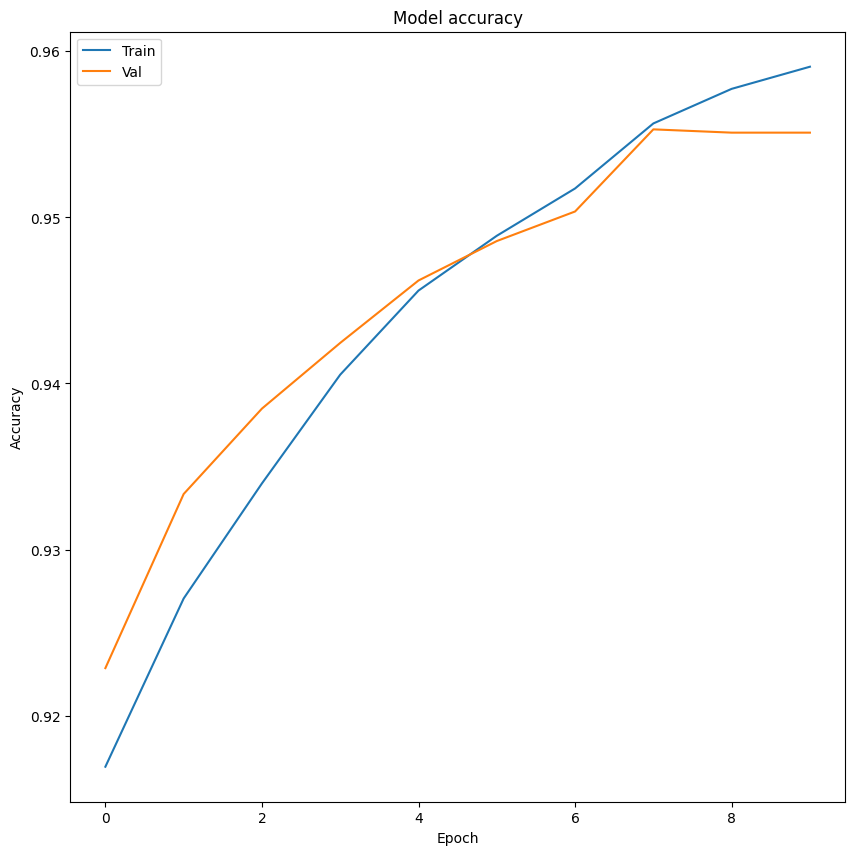

In [21]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history)
plt.plot(valid_accuracy_history)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

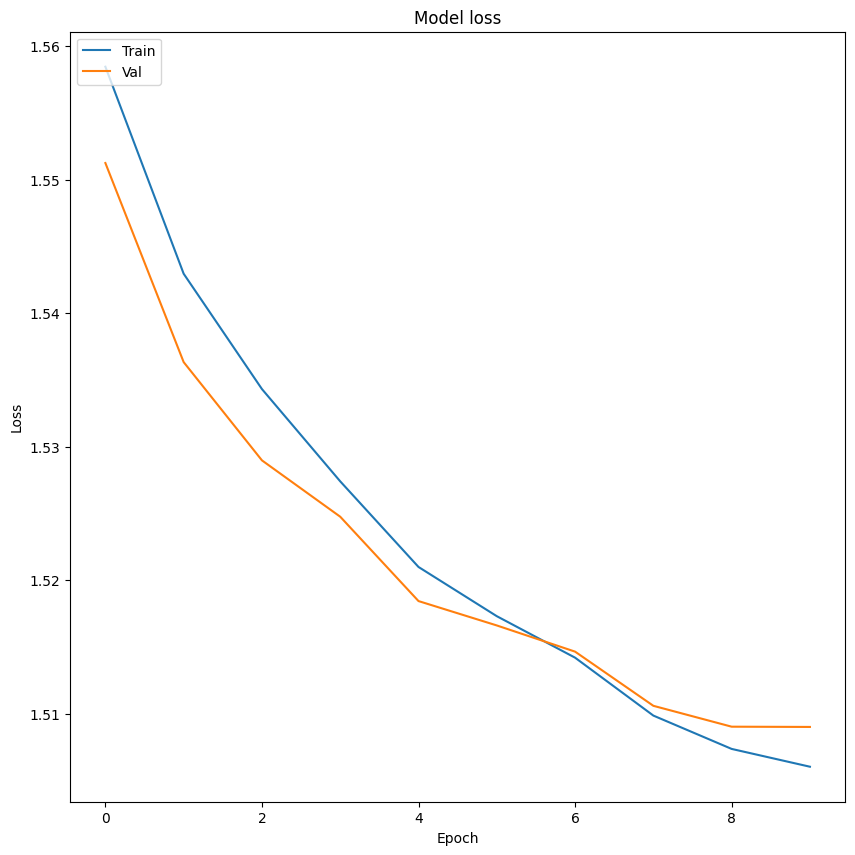

In [22]:
# Plot training and validation accuracy
plt.plot(train_loss_history)
plt.plot(valid_loss_history)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# 5. Evaluate the model.

In [23]:
# Calculate metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.5202, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9436, device='cuda:0')


# Exercise 1: Create a new model with 512 neurons in the hidden layer and repeat the process

In [27]:
# Design the model
class Franzi(nn.Module):                     # cualquier nombre de la red
    def __init__(self):                   # init siempre igual para decalar lasa capas de la red
        super(Franzi, self).__init__()       # en este caso: 2 capas fully-connected (= nn.Linear)
        self.fc1 = nn.Linear(784, 512)     # (variables de salida, num neuronas = num de clases)
        self.fc2 = nn.Linear(512, 10)  

    def forward(self, x):                # funcion como se conectan las capas
        x = x.view(-1, 784)              # hacer un reshape de x (los datos que entran); -1 la dimension del batch, 2° pixeles en una fila: 28*28
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)     # dim=0 es el batch, dim=1 son las clases
        return x

model = Franzi()

In [29]:
# Show summary of the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
summary(model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                   [-1, 10]           5,130
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [30]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):                         # iterar por cada epoch: en cada epoch 
    for i, (images, labels) in enumerate(train_loader): # recorre por todo el datasaet train_loader

        # Clear gradients (para reiniciarlos)
        optimizer.zero_grad()

        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass (con tu batch)            
        outputs = model(images)     # crear predicciones de nuestro batch

        # Compute loss
        loss = criterion(outputs, labels)     # calcular para luego poder cambiar los pesos del modelo

        # Backward pass 
        loss.backward()     # calcular los gradientes para los pesos

        # Update weights
        optimizer.step()    # en consequiencia de los gradientes que hemos calculado

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference  (eso no cambia la red, solo para poder ver como va nuestro modelo)
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 1.522 | Train accuracy: 0.945 | Valid loss: 1.520 | Valid accuracy: 0.945
Epoch 2/10 | Train loss: 1.497 | Train accuracy: 0.967 | Valid loss: 1.498 | Valid accuracy: 0.966
Epoch 3/10 | Train loss: 1.494 | Train accuracy: 0.970 | Valid loss: 1.497 | Valid accuracy: 0.967
Epoch 4/10 | Train loss: 1.484 | Train accuracy: 0.979 | Valid loss: 1.488 | Valid accuracy: 0.976
Epoch 5/10 | Train loss: 1.480 | Train accuracy: 0.983 | Valid loss: 1.485 | Valid accuracy: 0.977
Epoch 6/10 | Train loss: 1.477 | Train accuracy: 0.986 | Valid loss: 1.483 | Valid accuracy: 0.979
Epoch 7/10 | Train loss: 1.476 | Train accuracy: 0.987 | Valid loss: 1.485 | Valid accuracy: 0.977
Epoch 8/10 | Train loss: 1.474 | Train accuracy: 0.988 | Valid loss: 1.483 | Valid accuracy: 0.979
Epoch 9/10 | Train loss: 1.473 | Train accuracy: 0.989 | Valid loss: 1.483 | Valid accuracy: 0.979
Epoch 10/10 | Train loss: 1.472 | Train accuracy: 0.990 | Valid loss: 1.482 | Valid accuracy: 0.980


In [32]:
# Obtain metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(1.4875, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9737, device='cuda:0')


# Exercise 2: Add a hidden layer with 512 neurons to the model of exercise 1 and repeat the process

In [38]:
# Design the model
class Franzi(nn.Module):                     # cualquier nombre de la red
    def __init__(self):                   # init siempre igual para decalar lasa capas de la red
        super(Franzi, self).__init__()       # en este caso: 2 capas fully-connected (= nn.Linear)
        self.fc1 = nn.Linear(784, 512)     # (variables de salida, num neuronas = num de clases)
        self.fc2 = nn.Linear(512, 512)  
        self.fc3 = nn.Linear(512, 10) 

    def forward(self, x):                # funcion como se conectan las capas
        x = x.view(-1, 784)              # hacer un reshape de x (los datos que entran); -1 la dimension del batch, 2° pixeles en una fila: 28*28
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)     # dim=0 es el batch, dim=1 son las clases
        return x

model = Franzi()

In [39]:
# Show summary of the model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
summary(model.to(device), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
            Linear-2                  [-1, 512]         262,656
Total params: 664,576
Trainable params: 664,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.54
Estimated Total Size (MB): 2.55
----------------------------------------------------------------


In [35]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [36]:
# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss_history = []
valid_loss_history = []
train_accuracy_history = []
valid_accuracy_history = []

num_epochs = 10

for epoch in range(num_epochs):                         # iterar por cada epoch: en cada epoch 
    for i, (images, labels) in enumerate(train_loader): # recorre por todo el datasaet train_loader

        # Clear gradients (para reiniciarlos)
        optimizer.zero_grad()

        # Move images and labels to device (GPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass (con tu batch)            
        outputs = model(images)     # crear predicciones de nuestro batch

        # Compute loss
        loss = criterion(outputs, labels)     # calcular para luego poder cambiar los pesos del modelo

        # Backward pass 
        loss.backward()     # calcular los gradientes para los pesos

        # Update weights
        optimizer.step()    # en consequiencia de los gradientes que hemos calculado

    # Calculate accuracy
    train_loss = 0
    valid_loss = 0
    train_accuracy = 0
    valid_accuracy = 0

    # Turn off gradients for validation to speed up inference  (eso no cambia la red, solo para poder ver como va nuestro modelo)
    with torch.no_grad():
        for images, labels in train_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            train_loss += criterion(output, labels)

            # Calculate accuracy
            train_accuracy += get_accuracy(output, labels)
        
        train_loss_history.append(train_loss.cpu().numpy() / len(train_loader))
        train_accuracy_history.append(train_accuracy.cpu().numpy() / len(train_loader))

        for images, labels in valid_loader:

            # Move images and labels to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            output = model(images)

            # Calculate loss
            valid_loss += criterion(output, labels)

            # Calculate accuracy
            valid_accuracy += get_accuracy(output, labels)
        
        valid_loss_history.append(valid_loss.cpu().numpy() / len(valid_loader))
        valid_accuracy_history.append(valid_accuracy.cpu().numpy() / len(valid_loader))

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train loss: {train_loss/len(train_loader):.3f} | "
              f"Train accuracy: {train_accuracy/len(train_loader):.3f} | "
              f"Valid loss: {valid_loss/len(valid_loader):.3f} | "
              f"Valid accuracy: {valid_accuracy/len(valid_loader):.3f}")

Epoch 1/10 | Train loss: 2.582 | Train accuracy: 0.943 | Valid loss: 2.577 | Valid accuracy: 0.948
Epoch 2/10 | Train loss: 2.563 | Train accuracy: 0.960 | Valid loss: 2.563 | Valid accuracy: 0.960
Epoch 3/10 | Train loss: 2.553 | Train accuracy: 0.969 | Valid loss: 2.554 | Valid accuracy: 0.968
Epoch 4/10 | Train loss: 2.544 | Train accuracy: 0.977 | Valid loss: 2.547 | Valid accuracy: 0.973
Epoch 5/10 | Train loss: 2.540 | Train accuracy: 0.980 | Valid loss: 2.545 | Valid accuracy: 0.975
Epoch 6/10 | Train loss: 2.537 | Train accuracy: 0.983 | Valid loss: 2.544 | Valid accuracy: 0.976
Epoch 7/10 | Train loss: 2.534 | Train accuracy: 0.986 | Valid loss: 2.540 | Valid accuracy: 0.979
Epoch 8/10 | Train loss: 2.534 | Train accuracy: 0.986 | Valid loss: 2.541 | Valid accuracy: 0.978
Epoch 9/10 | Train loss: 2.531 | Train accuracy: 0.989 | Valid loss: 2.540 | Valid accuracy: 0.980
Epoch 10/10 | Train loss: 2.530 | Train accuracy: 0.989 | Valid loss: 2.538 | Valid accuracy: 0.982


In [37]:
# Obtain metrics in the test partition
test_loss = 0
test_accuracy = 0
for images, labels in test_loader:

    # Move images and labels to device
    images, labels = images.to(device), labels.to(device)
    
    # Forward pass
    output = model(images)

    # Calculate loss
    test_loss += criterion(output, labels)

    # Calculate accuracy
    test_accuracy += get_accuracy(output, labels)
print("Test loss:", test_loss / len(test_loader))
print("Test accuracy:", test_accuracy / len(test_loader))

Test loss: tensor(2.5463, device='cuda:0', grad_fn=<DivBackward0>)
Test accuracy: tensor(0.9733, device='cuda:0')
